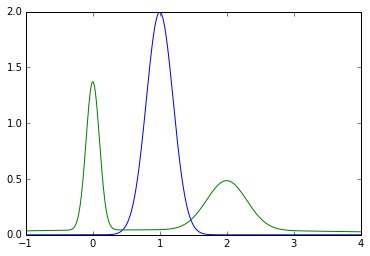

In [1]:

# coding: utf-8

# In[4]:

from __future__ import division

import numpy as np
import time
import random
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import norm
import matplotlib.cm as cm
from scipy.interpolate import interp1d
from mpl_toolkits.mplot3d import Axes3D
from random import randint
import sklearn as sk
from sklearn.neighbors import NearestNeighbors

%matplotlib inline  

def sample_rho_batch(rho_list,nsamples):
   
    sample = np.zeros([nsamples,D])
    nrho = len(rho_list)
    for i in range(nsamples):
        rand = np.random.rand(1)
        idx = int(np.floor(nrho * rand))
        sample[i,:] = rho_list[idx].rvs()
        
    return sample

def sample_rho(rho_list):
    nrho = len(rho_list)
    rand = np.random.rand(1)
    idx = int(np.floor(nrho * rand))
    sample = rho_list[idx].rvs()

    return sample



D = 1
p = 2

np.random.seed(5)


mu1 = 0
mu2 = 2
mu3 = 1
sigma1 = 0.1
sigma2 = 0.3 
sigma3 = 3
rho1 = norm(loc = mu1,scale = sigma1)
rho2 = norm(loc = mu2,scale = sigma2)
rho3 = norm(loc = mu3,scale = sigma3)

rho_list_target  = [rho1,rho2,rho3]


mu_1 = 1
sigma_1 = 0.2 
rho_1 = norm(loc = mu_1,scale = sigma_1)
rho_list_source = [rho_1]



x = np.linspace(-1,4,1000)

N = np.size(x)

rho_vect_source = np.zeros(np.shape(x))
rho_vect_target = np.zeros(np.shape(x))
nrho_source = 1
nrho_target = 3

for i in range(nrho_source):
    rho_vect_source += 1./nrho_source * rho_list_source[i].pdf(x)
for i in range(nrho_target):
    rho_vect_target += 1./nrho_target * rho_list_target[i].pdf(x)

plt.plot(x,rho_vect_source)
plt.plot(x,rho_vect_target)
plt.show()


In [2]:


# # discrete sample from measure 1 for evaluations of u
#n_source = len(x_u)
#X_source = np.reshape(x_u,[n_source,1])

n_source = 10**3
x_u = (sample_rho_batch(rho_list_source,n_source))
x_u = np.sort(np.reshape(x_u,[1,n_source]))
#x_u = np.linspace(-1,4,n_source)
X_source = np.reshape(x_u,[n_source,1])



# discrete sample from measure 2
n_target = 10**3

x_v = (sample_rho_batch(rho_list_target,n_target))
x_v = np.sort(np.reshape(x_v,[1,n_target]))
X_target = np.reshape(x_v,[n_target,1])


nu = np.ones(n_target)/n_target




C = np.zeros([n_source,n_target])
for i in range(n_source):
    for j in range(n_target):
        C[i,j] = np.sum(abs(X_source[i,:]-X_target[j,:])**2)


epsilon = 10**(-1)


In [ ]:


def gradient(v_eps,epsilon,n_target,rho_source,X_target,nu):
    expv = np.zeros(n_target)
    while np.sum(expv) == 0:
        Y = sample_rho(rho_source)
        z = np.max(v_eps-np.sum((X_target-Y)**2,axis=1)/epsilon)
        expv = nu * np.exp(v_eps-np.sum((X_target-Y)**2,axis=1)/epsilon - z)
        #if np.sum(expv) == 0:
        #print "simulate again"
    pi = expv/np.sum(expv)
    grad = - nu + pi
    return grad


def runSGD (epsilon,nb_iter,n_target,n_source,rho_source,X_target,X_source,nu,alpha,C) :
    t = time.time()
    vlist = np.zeros([n_target,nb_iter])
    ulist = np.zeros([n_source,int(nb_iter/100)])
    u_SGD = np.zeros(n_source)


    v_eps_bar = np.ones(n_target)
    v_eps = np.ones(n_target)
        
    for i in range(nb_iter) :
        if i%10**5 == 0:
            print i/10**5
        vlist[:,i] = epsilon * v_eps_bar
        step = n_target * alpha*(1./np.sqrt(i+1))
        grad = gradient(v_eps,epsilon,n_target,rho_source,X_target,nu)
        v_eps = v_eps - step*grad
        v_eps_bar = 1./(i+1)*(v_eps + i*v_eps_bar)
        #if i%100 == 0 :
        #   for k in range(n_source):
        #       z = np.max(epsilon*v_eps_bar-C[k,:])
        #       u_SGD[k] = - z - epsilon * ( np.log(np.sum(np.exp((epsilon*v_eps_bar-C[k,:]-z)/epsilon)*nu)))
        #   ulist[:,int(i/100)] = u_SGD    

    tt = time.time()-t
    print 'SGD time elapsed ' + str(tt) 
    return [vlist,ulist]


# In[86]:

alpha = .8/epsilon

nb_iter_SGD = 10**6

[v_SGD_list,u_SGD_list] = runSGD (epsilon,nb_iter_SGD,n_target,n_source,rho_list_source,X_target,X_source, nu,alpha,C)

v_SGD = v_SGD_list[:,-1]

err_SGD = np.zeros(nb_iter_SGD)
for i in range(nb_iter_SGD):
    err_SGD[i] = np.linalg.norm(v_SGD_list[:,i] - np.mean(v_SGD_list[:,i]) - v_SGD )/np.linalg.norm(v_SGD)


# In[88]:

# In[89]:

u_SGD = np.zeros(n_source)

for i in range(n_source):
    z1 = np.max(v_SGD-C[i,:])
    u_SGD[i] = - z1 - epsilon * ( np.log(np.sum(np.exp((v_SGD-C[i,:]-z1)/epsilon)*nu)))
    

In [ ]:
plt.loglog(err_SGD)
plt.show()

In [ ]:

# ## RKHS

# In[110]:

def k(X,Y,sigma):
    k =np.exp(-np.sum((X-Y)**2,axis=1)/(2*sigma))
    return k


# In[111]:

def c(x,y):
    c = np.sum((x-y)**2)
    return c


# In[123]:



a = .1

sigma_list = [0.005]

nb_iter_rkhs = 6*10**5
n_runs = 1
n_samples = 1

for sigma in sigma_list:

    t = time.time()

    u_rkhs_averaged = np.zeros([n_source,nb_iter_rkhs])
    v_rkhs_averaged = np.zeros([n_target,nb_iter_rkhs])


    for j in range(n_runs):
        alpha_vect = np.zeros(nb_iter_rkhs)
        Xsamples = np.zeros([nb_iter_rkhs,D])
        Ysamples = np.zeros([nb_iter_rkhs,D])
        u_rkhs = np.zeros(n_source)
        v_rkhs = np.zeros(n_target)
        u_bar = np.zeros(n_source)
        v_bar = np.zeros(n_target)


        for i in range(nb_iter_rkhs) :
            if i%10**5 == 0:
                print i/10**5
            step = a*(1./np.sqrt(i+1))
            xi = sample_rho(rho_list_source)
            yi = sample_rho(rho_list_target)
            Xsamples[i,:] = xi
            Ysamples[i,:] = yi
        
            u = np.sum(alpha_vect[:i-1]*k(Xsamples[:i-1,:],xi,sigma))
        
            v = np.sum(alpha_vect[:i-1]*k(Ysamples[:i-1,:],yi,sigma))
        
            alpha = step*(1-np.exp((u+v-c(xi,yi))/epsilon))
            #alpha = step*(1-2*max(0,(u+v-c(xi,yi))/epsilon))
            alpha_vect[i] = alpha
        
            u_rkhs += alpha*k(xi,X_source,sigma)
            v_rkhs += alpha*k(yi,X_target,sigma)
        
            u_bar = 1./(i+1)*(i*u_bar + u_rkhs)
            u_rkhs_averaged[:,i] = u_bar

            v_bar = 1./(i+1)*(i*v_bar + v_rkhs)
            v_rkhs_averaged[:,i] = v_bar


    tt = time.time()-t
    print 'RKHS time elapsed ' + str(tt)

    u_rkhs = u_rkhs_averaged[:,-1]
    v_rkhs = v_rkhs_averaged[:,-1]


   

np.save("alpha",alpha_vect)
np.save("x_rkhs",Xsamples)
np.save("y_rkhs",Ysamples)


In [ ]:
3+3

In [ ]:
 #convergence RKHS
err_u = np.zeros(np.shape(u_rkhs_averaged)[1])

for i in range(np.shape(u_rkhs_averaged)[1]):
    err_u[i] = np.linalg.norm(u_rkhs_averaged[:,i]-np.mean(u_rkhs_averaged[:,i])-(u_SGD-np.mean(u_SGD)))/np.linalg.norm(u_SGD-np.mean(u_SGD))
    


In [ ]:

plt.figure()


#plt.ylim([10**(-2),2])
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 

# In[126]:
plt.figure()
plt.plot((X_source.T)[0],u_rkhs_averaged[:,10**3]-np.max(u_rkhs_averaged[:,10**3]),label = 'u - RKHS - 10**3',linewidth = 2,alpha = 0.3,color = 'g')
plt.plot((X_source.T)[0],u_rkhs_averaged[:,10**4]-np.max(u_rkhs_averaged[:,10**4]),label = 'u - RKHS - 10**4',linewidth = 2,alpha = 0.6,color = 'g')
plt.plot((X_source.T)[0],u_rkhs-np.max(u_rkhs),label = 'u - RKHS - 10**5',linewidth = 2,color ='g')
plt.plot((X_source.T)[0],u_SGD-np.max(u_SGD),label = 'u - SGD',linewidth = 2,linestyle = '--',color = 'r')
#plt.plot((X_source.T)[0],u_SGD_list[:,-1]-np.mean(u_SGD_list[:,-1]),label = 'u - SGD',linewidth = 2,linestyle = '--',color = 'r',alpha = 0.5)

#plt.scatter(X_source,-1.5*np.ones(n_source),s=50,c='b',alpha=0.05,edgecolors = 'face',linewidth = 0)

plt.xlim([0.45,1.55])

plt.ylim([-1.5,0.1])





plt.legend(loc = 0)

plt.show()




plt.savefig('plot_u_rkhs.eps', format='eps', dpi=1000)

In [ ]:
plt.semilogx(err_u[:n_max],label = "SGD in RKHS",linewidth = 2, color = 'g')
plt.xlim([0,n_max])
plt.show()
plt.savefig('cv_u_rkhs.eps', format='eps', dpi=1000)